In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.utils
from torch.autograd import Variable

import torchvision.models as models
import torchvision.transforms as transforms

from torch import optim
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import random_split

from collections import namedtuple, defaultdict
from datetime import datetime
from sklearn.metrics import confusion_matrix

import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import random
import seaborn as sns

In [2]:
def load_dataset(user_split = True):
    X_train = None
    y_train_medid = None
    y_train_subjid = None
    y_train_ts = None
    
    X_val = None
    y_val_medid = None
    y_val_subjid = None
    y_val_ts = None
    
    X_test = None
    y_test_medid = None
    y_test_subjid = None
    y_test_ts = None

    # user_split: Determines the creation of train/val/test set. In user_split, test/val users are never seen during the train. time_split randomly splits each user's chunks into train/val/test.
    if user_split:
        data_file_path = './data/Meditation/user_based_splits_with_timestamp.pkl'
    else:
        data_file_path = './data/Meditation/time_based_splits_with_timestamp.pkl'

    with open(data_file_path, 'rb') as f:
        all_data_splits = pickle.load(f)

        X_train = all_data_splits['train']['x']
        y_train_medid = all_data_splits['train']['y_med']
        y_train_subjid = all_data_splits['train']['y_subj']
        y_train_ts = all_data_splits['train']['y_ts']

        X_val = all_data_splits['val']['x']
        y_val_medid = all_data_splits['val']['y_med']
        y_val_subjid = all_data_splits['val']['y_subj']
        y_val_ts = all_data_splits['val']['y_ts']

        X_test = all_data_splits['test']['x']
        y_test_medid = all_data_splits['test']['y_med']
        y_test_subjid = all_data_splits['test']['y_subj']
        y_test_ts = all_data_splits['test']['y_ts']

    return X_train, y_train_medid, y_train_subjid, y_train_ts, X_val, y_val_medid, y_val_subjid, y_val_ts, X_test, y_test_medid, y_test_subjid, y_test_ts

In [3]:
X_train, y_train_medid, y_train_subjid, y_train_ts, X_val, y_val_medid, y_val_subjid, y_val_ts, \
X_test, y_test_medid, y_test_subjid, y_test_ts = load_dataset(user_split=True)

In [4]:
type(X_train), X_train.shape

(numpy.ndarray, (2057, 64, 2560))

Create the triples

In [5]:
# def get_pos_neg_pairs():
    
pos_neg_pairs = []

X_train, y_train_medid, y_train_subjid, y_train_ts, X_val, y_val_medid, y_val_subjid, y_val_ts, \
X_test, y_test_medid, y_test_subjid, y_test_ts = load_dataset(user_split=True)

# Create appropriate X_train, y_train, X_test, y_test
y_train = y_train_medid
y_val = y_val_medid
y_train = np.concatenate((y_train_medid, y_val_medid), axis=0)

y_test = y_test_medid

shape0 = X_train.shape[0]
X_train = X_train.transpose().reshape(shape0, 64, 40, 64).mean(axis=2)
shape0 = X_val.shape[0]
X_val = X_val.transpose().reshape(shape0, 64, 40, 64).mean(axis=2)
X_train = np.concatenate((X_train, X_val), axis=0)

shape0 = X_test.shape[0]
X_test = X_test.transpose().reshape(shape0, 64, 40, 64).mean(axis=2)

for i, data1 in enumerate(zip(X_train, y_train)):
    for j, data2 in enumerate(zip(X_train, y_train)):
        if i == j:
            continue
        else:
            if data1[1] == data2[1]:
                pos_neg_pairs.append((data1[0], data2[0], 1))
            else:
                pos_neg_pairs.append((data1[0], data2[0], 0))
                    
# return pos_neg_pairs

In [6]:
#pos_neg_pairs = get_pos_neg_pairs()
len(pos_neg_pairs)

7222656

In [7]:
random.shuffle(pos_neg_pairs)
pos_neg_pairs = pos_neg_pairs[0:10000]
print(len(pos_neg_pairs))

10000


In [8]:
class ResidualBlock(nn.Module):
    # Residual block
    def __init__(self, input_channels, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels, kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels, kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

def get_resnet_block(input_channels, num_channels, num_residuals, first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(ResidualBlock(input_channels, num_channels, use_1x1conv=True, strides=2))
        else:
            blk.append(ResidualBlock(num_channels, num_channels))
    return blk


class CustomResNet:

    def __init__(self, input_size, output_size, hparams=None, model_name='ResNet'):
        b2, b3, b4, b5 = CustomResNet.get_blocks()
        b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
        self.model = nn.Sequential(b1, b2, b3, b4, b5, nn.AdaptiveAvgPool2d((1,1)), nn.Flatten(), nn.Linear(512, 10))
        self.name = model_name
        return

    def get_model(self):
        return self.model

    @staticmethod
    def get_blocks():
        b2 = nn.Sequential(*get_resnet_block(64, 64, 2, first_block=True))
        b3 = nn.Sequential(*get_resnet_block(64, 128, 2))
        b4 = nn.Sequential(*get_resnet_block(128, 256, 2))
        b5 = nn.Sequential(*get_resnet_block(256, 512, 2))
        return b2, b3, b4, b5

In [9]:
#create the Siamese Neural Network
class SiameseNetwork(nn.Module):

    def __init__(self):
        super(SiameseNetwork, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, 10),  # 64@96*96
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 64@48*48
            nn.Conv2d(64, 128, 7),
            nn.ReLU(),    # 128@42*42
            nn.MaxPool2d(2),   # 128@21*21
            nn.Conv2d(128, 128, 2),
            nn.ReLU(), # 128@18*18
            nn.MaxPool2d(2), # 128@9*9
            nn.Conv2d(128, 256, 2),
            nn.ReLU(),   # 256@6*6
        )
        self.liner = nn.Sequential(nn.Linear(2304, 4096), nn.Sigmoid())
        self.out = nn.Linear(4096, 2)
        
    def forward_once(self, x):
        # This function will be called for both images
        # It's output is used to determine the similiarity
        output = self.conv(x)
        output = output.view(output.size()[0], -1)
        output = self.liner(output)
        return output

    def forward(self, input1, input2):
        # In this function we pass in both images and obtain both vectors
        # which are returned
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)

        return output1, output2


In [10]:
# Define the Contrastive Loss Function
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        # Calculate the euclidian distance and calculate the contrastive loss
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)

        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) + (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive

In [11]:
def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [12]:
input_size = 64*64
output_size = 4

net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.001)

In [13]:
counter = []
loss_history = [] 
iteration_number= 0
batch_size = 1000

# Iterate throught the epochs
for epoch in range(1):

    # Iterate over batches
    for i in range(0, len(pos_neg_pairs), batch_size):
        img_trip = pos_neg_pairs[i:i+batch_size]
        img0  = []
        img1  = []
        label = []
        for batch_instance in img_trip:
            img0.append(np.array(batch_instance[0]))
            img1.append(np.array(batch_instance[1]))
            label.append(np.array(batch_instance[2]))
        
        img0 = np.array(img0)
        img1 = np.array(img1)
        label = np.array(label)
        
        img0 = np.reshape(img0, (batch_size, 1, 64, 64))
        img1 = np.reshape(img1, (batch_size, 1, 64, 64))
        label = np.reshape(label, (batch_size, 1))
        
        img0 = torch.Tensor(img0)
        img1 = torch.Tensor(img1)
        label = torch.Tensor(label)

        # Send the images and labels to CUDA
        img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()

        # Zero the gradients
        optimizer.zero_grad()

        # Pass in the two images into the network and obtain two outputs
        output1, output2 = net(img0, img1)

        # Pass the outputs of the networks and label into the loss function
        loss_contrastive = criterion(output1, output2, label)

        # Calculate the backpropagation
        loss_contrastive.backward()

        # Optimize
        optimizer.step()

        # Every 10 batches print out the loss
        if i % 10 == 0 :
            print(f"Epoch number {epoch} Step number {i} \n Current loss {loss_contrastive.item()}\n")
            iteration_number += 10

            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())

RuntimeError: CUDA out of memory. Tried to allocate 740.00 MiB (GPU 0; 31.75 GiB total capacity; 3.32 GiB already allocated; 564.25 MiB free; 3.97 GiB reserved in total by PyTorch)
Exception raised from malloc at /pytorch/c10/cuda/CUDACachingAllocator.cpp:272 (most recent call first):
frame #0: c10::Error::Error(c10::SourceLocation, std::string) + 0x42 (0x7f2aa09c61e2 in /home/singh_shruti/.local/lib/python3.8/site-packages/torch/lib/libc10.so)
frame #1: <unknown function> + 0x1e64b (0x7f2aa0c1c64b in /home/singh_shruti/.local/lib/python3.8/site-packages/torch/lib/libc10_cuda.so)
frame #2: <unknown function> + 0x1f464 (0x7f2aa0c1d464 in /home/singh_shruti/.local/lib/python3.8/site-packages/torch/lib/libc10_cuda.so)
frame #3: <unknown function> + 0x1faa1 (0x7f2aa0c1daa1 in /home/singh_shruti/.local/lib/python3.8/site-packages/torch/lib/libc10_cuda.so)
frame #4: at::native::empty_cuda(c10::ArrayRef<long>, c10::TensorOptions const&, c10::optional<c10::MemoryFormat>) + 0x11e (0x7f2a4bd3890e in /home/singh_shruti/.local/lib/python3.8/site-packages/torch/lib/libtorch_cuda.so)
frame #5: <unknown function> + 0xf33949 (0x7f2a4a172949 in /home/singh_shruti/.local/lib/python3.8/site-packages/torch/lib/libtorch_cuda.so)
frame #6: <unknown function> + 0xf4d777 (0x7f2a4a18c777 in /home/singh_shruti/.local/lib/python3.8/site-packages/torch/lib/libtorch_cuda.so)
frame #7: <unknown function> + 0x10e9c7d (0x7f2a84f28c7d in /home/singh_shruti/.local/lib/python3.8/site-packages/torch/lib/libtorch_cpu.so)
frame #8: <unknown function> + 0x10e9f97 (0x7f2a84f28f97 in /home/singh_shruti/.local/lib/python3.8/site-packages/torch/lib/libtorch_cpu.so)
frame #9: at::empty(c10::ArrayRef<long>, c10::TensorOptions const&, c10::optional<c10::MemoryFormat>) + 0xfa (0x7f2a85033a1a in /home/singh_shruti/.local/lib/python3.8/site-packages/torch/lib/libtorch_cpu.so)
frame #10: at::native::empty_like(at::Tensor const&, c10::TensorOptions const&, c10::optional<c10::MemoryFormat>) + 0x49e (0x7f2a84cb1c3e in /home/singh_shruti/.local/lib/python3.8/site-packages/torch/lib/libtorch_cpu.so)
frame #11: <unknown function> + 0x12880c1 (0x7f2a850c70c1 in /home/singh_shruti/.local/lib/python3.8/site-packages/torch/lib/libtorch_cpu.so)
frame #12: <unknown function> + 0x12c3863 (0x7f2a85102863 in /home/singh_shruti/.local/lib/python3.8/site-packages/torch/lib/libtorch_cpu.so)
frame #13: at::empty_like(at::Tensor const&, c10::TensorOptions const&, c10::optional<c10::MemoryFormat>) + 0x101 (0x7f2a85016b31 in /home/singh_shruti/.local/lib/python3.8/site-packages/torch/lib/libtorch_cpu.so)
frame #14: at::native::zeros_like(at::Tensor const&, c10::TensorOptions const&, c10::optional<c10::MemoryFormat>) + 0x46 (0x7f2a84cab6f6 in /home/singh_shruti/.local/lib/python3.8/site-packages/torch/lib/libtorch_cpu.so)
frame #15: <unknown function> + 0x128b434 (0x7f2a850ca434 in /home/singh_shruti/.local/lib/python3.8/site-packages/torch/lib/libtorch_cpu.so)
frame #16: <unknown function> + 0x12c3863 (0x7f2a85102863 in /home/singh_shruti/.local/lib/python3.8/site-packages/torch/lib/libtorch_cpu.so)
frame #17: at::zeros_like(at::Tensor const&, c10::TensorOptions const&, c10::optional<c10::MemoryFormat>) + 0x101 (0x7f2a85016dd1 in /home/singh_shruti/.local/lib/python3.8/site-packages/torch/lib/libtorch_cpu.so)
frame #18: at::native::max_pool2d_with_indices_backward_cuda(at::Tensor const&, at::Tensor const&, c10::ArrayRef<long>, c10::ArrayRef<long>, c10::ArrayRef<long>, c10::ArrayRef<long>, bool, at::Tensor const&) + 0x63 (0x7f2a4b0c5983 in /home/singh_shruti/.local/lib/python3.8/site-packages/torch/lib/libtorch_cuda.so)
frame #19: <unknown function> + 0xf2e801 (0x7f2a4a16d801 in /home/singh_shruti/.local/lib/python3.8/site-packages/torch/lib/libtorch_cuda.so)
frame #20: <unknown function> + 0xf4fd9f (0x7f2a4a18ed9f in /home/singh_shruti/.local/lib/python3.8/site-packages/torch/lib/libtorch_cuda.so)
frame #21: at::max_pool2d_with_indices_backward(at::Tensor const&, at::Tensor const&, c10::ArrayRef<long>, c10::ArrayRef<long>, c10::ArrayRef<long>, c10::ArrayRef<long>, bool, at::Tensor const&) + 0x1ac (0x7f2a85025a2c in /home/singh_shruti/.local/lib/python3.8/site-packages/torch/lib/libtorch_cpu.so)
frame #22: <unknown function> + 0x2ecf64d (0x7f2a86d0e64d in /home/singh_shruti/.local/lib/python3.8/site-packages/torch/lib/libtorch_cpu.so)
frame #23: <unknown function> + 0x111485f (0x7f2a84f5385f in /home/singh_shruti/.local/lib/python3.8/site-packages/torch/lib/libtorch_cpu.so)
frame #24: at::max_pool2d_with_indices_backward(at::Tensor const&, at::Tensor const&, c10::ArrayRef<long>, c10::ArrayRef<long>, c10::ArrayRef<long>, c10::ArrayRef<long>, bool, at::Tensor const&) + 0x1ac (0x7f2a85025a2c in /home/singh_shruti/.local/lib/python3.8/site-packages/torch/lib/libtorch_cpu.so)
frame #25: torch::autograd::generated::MaxPool2DWithIndicesBackward::apply(std::vector<at::Tensor, std::allocator<at::Tensor> >&&) + 0x248 (0x7f2a86b852f8 in /home/singh_shruti/.local/lib/python3.8/site-packages/torch/lib/libtorch_cpu.so)
frame #26: <unknown function> + 0x3375bb7 (0x7f2a871b4bb7 in /home/singh_shruti/.local/lib/python3.8/site-packages/torch/lib/libtorch_cpu.so)
frame #27: torch::autograd::Engine::evaluate_function(std::shared_ptr<torch::autograd::GraphTask>&, torch::autograd::Node*, torch::autograd::InputBuffer&, std::shared_ptr<torch::autograd::ReadyQueue> const&) + 0x1400 (0x7f2a871b0400 in /home/singh_shruti/.local/lib/python3.8/site-packages/torch/lib/libtorch_cpu.so)
frame #28: torch::autograd::Engine::thread_main(std::shared_ptr<torch::autograd::GraphTask> const&) + 0x451 (0x7f2a871b0fa1 in /home/singh_shruti/.local/lib/python3.8/site-packages/torch/lib/libtorch_cpu.so)
frame #29: torch::autograd::Engine::thread_init(int, std::shared_ptr<torch::autograd::ReadyQueue> const&, bool) + 0x89 (0x7f2a871a9119 in /home/singh_shruti/.local/lib/python3.8/site-packages/torch/lib/libtorch_cpu.so)
frame #30: torch::autograd::python::PythonEngine::thread_init(int, std::shared_ptr<torch::autograd::ReadyQueue> const&, bool) + 0x4a (0x7f2aa177386a in /home/singh_shruti/.local/lib/python3.8/site-packages/torch/lib/libtorch_python.so)
frame #31: <unknown function> + 0xc9039 (0x7f2ab440b039 in /home/singh_shruti/anaconda3/envs/compneuro/bin/../lib/libstdc++.so.6)
frame #32: <unknown function> + 0x8609 (0x7f2ab72c5609 in /lib/x86_64-linux-gnu/libpthread.so.0)
frame #33: clone + 0x43 (0x7f2ab71ea163 in /lib/x86_64-linux-gnu/libc.so.6)


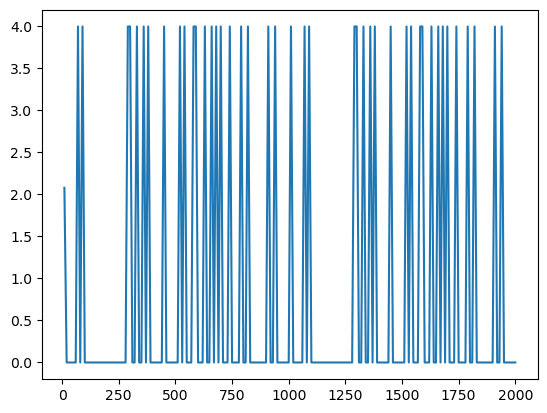

In [25]:
show_plot(counter, loss_history)

In [26]:
type(net)

__main__.SiameseNetwork

In [43]:
X_train, y_train_medid, y_train_subjid, y_train_ts, X_val, y_val_medid, y_val_subjid, y_val_ts, \
X_test, y_test_medid, y_test_subjid, y_test_ts = load_dataset(user_split=True)
X_test.shape

(615, 64, 2560)

In [45]:
X_test = X_test.transpose().reshape(X_test.shape[0], 64, 40, 64).mean(axis=2)
X_test.shape

(615, 64, 64)

In [47]:
test_ops = net.forward_once(torch.Tensor(X_test.reshape(X_test.shape[0], 1, 64, 64)).cuda())
print(test_ops.shape)

torch.Size([615, 4096])

In [48]:
# Repeat above for the train set as well

y_train = y_train_medid
y_val = y_val_medid
y_train = np.concatenate((y_train_medid, y_val_medid), axis=0)

shape0 = X_train.shape[0]
X_train = X_train.transpose().reshape(shape0, 64, 40, 64).mean(axis=2)
shape0 = X_val.shape[0]
X_val = X_val.transpose().reshape(shape0, 64, 40, 64).mean(axis=2)
X_train = np.concatenate((X_train, X_val), axis=0)
print("Xtrain collated shape: ", X_train.shape)
print("y_train collated shape: ", y_train.shape)
train_ops = net.forward_once(torch.Tensor(X_train.reshape(X_train.shape[0], 1, 64, 64)).cuda())
print("X_train embeddings shape: ", train_ops.shape)

Xtrain collated shape:  (2688, 64, 64)
y_train collated shape:  (4114,)


RuntimeError: CUDA out of memory. Tried to allocate 1.94 GiB (GPU 0; 31.75 GiB total capacity; 1.40 GiB already allocated; 1.69 GiB free; 2.83 GiB reserved in total by PyTorch)

### Plot the tSNE 

In [42]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from collections import Counter
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import pandas as pd
import time
import pickle
import glob

In [ ]:
# def tsne_compute(dataset_name, model_name, tneigh='titles', perplexity=50):
X_emb_df = pd.DataFrame(columns=list(range(0, 768)), dtype=float)
y_df = pd.DataFrame(columns=["target"])

specter_vecs_titles = pickle.load(open('datasets/{}/emb/{}/emb_{}.pkl'.format(dataset_name, model_name, tneigh), 'rb'))
count = 0
for pid in specter_vecs_titles:
    if pid!='name':
        if model_name == 'specter':
            X_emb_df.loc[pid+"_T"] = list(specter_vecs_titles[pid].reshape(768,))
        else:
            X_emb_df.loc[pid+"_T"] = list(specter_vecs_titles[pid].reshape(768,))
        y_df.loc[pid+"_T"] = tneigh
        count += 1
#         if count > 50:
#             break


specter_vecs_titles = pickle.load(open('datasets/{}/emb/{}/emb_tabs.pkl'.format(dataset_name, model_name), 'rb'))
count = 0
for pid in specter_vecs_titles:
    if pid!='name':
        if model_name == 'specter':
            X_emb_df.loc[pid+"_TA"] = list(specter_vecs_titles[pid].reshape(768,))
        else:
            X_emb_df.loc[pid+"_TA"] = list(specter_vecs_titles[pid].reshape(768,))
        y_df.loc[pid+"_TA"] = 'Title+Abs'
        count += 1
#         if count > 50:
#             break

X_emb_df["Embedding"] = y_df

df_res = X_emb_df.copy()
feat_columns = list(range(0, 768))
data_for_tsne = df_res[feat_columns].values

print("Starting t-SNE now!")
time_start = time.time()
tsne = TSNE(n_components=2, verbose=0, perplexity=perplexity)#, n_iter=251)
tsne_results = tsne.fit_transform(data_for_tsne)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

df_res['tsne-2d-one'] = tsne_results[:,0]
df_res['tsne-2d-two'] = tsne_results[:,1]
#return df_res

fig, axs = plt.subplots(1, 1, sharey=True,dpi=200)
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", hue="Embedding", palette = sns.color_palette("bright", 2),
                data=df_res,legend="full", s=3)
plt.xticks([])
plt.yticks([])
plt.savefig("figures/tsne.png".format(dataset_name, model_name, tneigh), bbox_inches='tight', pad_inches=0.05)

In [ ]:
df_res = tsne_compute()

In [ ]:
# Locate the test dataset and load it into the SiameseNetworkDataset
folder_dataset_test = datasets.ImageFolder(root="./data/faces/testing/")
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transformation)
test_dataloader = DataLoader(siamese_dataset, num_workers=2, batch_size=1, shuffle=True)

# Grab one image that we are going to test
dataiter = iter(test_dataloader)
x0, _, _ = next(dataiter)

for i in range(10):
    # Iterate over 10 images and test them with the first image (x0)
    _, x1, label2 = next(dataiter)

    # Concatenate the two images together
    concatenated = torch.cat((x0, x1), 0)
    
    output1, output2 = net(x0.cuda(), x1.cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated), f'Dissimilarity: {euclidean_distance.item():.2f}')

## Other code snippets

In [ ]:
# #create the Siamese Neural Network
# class SiameseNetwork(nn.Module):

#     def __init__(self, input_size, output_size):
#         super(SiameseNetwork, self).__init__()

#         self.model = CustomResNet(input_size, output_size).get_model()
        
#     def forward_once(self, x):
#         # This function will be called for both images
#         # It's output is used to determine the similiarity
#         output = self.model(x)
#         return output

#     def forward(self, input1, input2):
#         # In this function we pass in both images and obtain both vectors
#         # which are returned
#         output1 = self.forward_once(input1)
#         output2 = self.forward_once(input2)

#         return output1, output2
    
#     def get_model(self):
#         return self.model

In [ ]:
# #create the Siamese Neural Network
# class SiameseNetwork(nn.Module):

#     def __init__(self):
#         super(SiameseNetwork, self).__init__()

#         # Setting up the Sequential of CNN Layers
#         self.cnn1 = nn.Sequential(
#             nn.Conv2d(1, 96, kernel_size=11,stride=4),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(3, stride=2),
            
#             nn.Conv2d(96, 256, kernel_size=5, stride=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(2, stride=2),

#             nn.Conv2d(256, 384, kernel_size=3,stride=1),
#             nn.ReLU(inplace=True)
#         )

#         # Setting up the Fully Connected Layers
#         self.fc1 = nn.Sequential(
#             nn.Linear(384, 1024),
#             nn.ReLU(inplace=True),
            
#             nn.Linear(1024, 256),
#             nn.ReLU(inplace=True),
            
#             nn.Linear(256,2)
#         )
        
#     def forward_once(self, x):
#         # This function will be called for both images
#         # It's output is used to determine the similiarity
#         output = self.cnn1(x)
#         output = output.view(output.size()[0], -1)
#         output = self.fc1(output)
#         return output

#     def forward(self, input1, input2):
#         # In this function we pass in both images and obtain both vectors
#         # which are returned
#         output1 = self.forward_once(input1)
#         output2 = self.forward_once(input2)

#         return output1, output2

In [ ]:
# class SiameseNetworkDataset(Dataset):
#     def __init__(self,imageFolderDataset,transform=None):
#         self.imageFolderDataset = imageFolderDataset    
#         self.transform = transform
        
#     def __getitem__(self,index):
#         img0_tuple = random.choice(self.imageFolderDataset.imgs)

#         #We need to approximately 50% of images to be in the same class
#         should_get_same_class = random.randint(0,1) 
#         if should_get_same_class:
#             while True:
#                 #Look untill the same class image is found
#                 img1_tuple = random.choice(self.imageFolderDataset.imgs) 
#                 if img0_tuple[1] == img1_tuple[1]:
#                     break
#         else:

#             while True:
#                 #Look untill a different class image is found
#                 img1_tuple = random.choice(self.imageFolderDataset.imgs) 
#                 if img0_tuple[1] != img1_tuple[1]:
#                     break

#         img0 = Image.open(img0_tuple[0])
#         img1 = Image.open(img1_tuple[0])

#         img0 = img0.convert("L")
#         img1 = img1.convert("L")

#         if self.transform is not None:
#             img0 = self.transform(img0)
#             img1 = self.transform(img1)
        
#         return img0, img1, torch.from_numpy(np.array([int(img1_tuple[1] != img0_tuple[1])], dtype=np.float32))
    
#     def __len__(self):
#         return len(self.imageFolderDataset.imgs)